In [1]:
import io
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa

2021-10-07 23:42:16.219351: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [2]:
import os  
import cv2
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder

# Loading np array from images
def make_dataset(labels, dir_path, IMG_SIZE = 150):
    # initial an empty list X to store image of np.array()
    X = []

    # initial an empty list Z to store labels/names of cat individauls
    Z = []
    for label in labels:
        DIR = dir_path + label
        for img in tqdm(os.listdir(DIR)):
            path = os.path.join(DIR,img)
            # reading images
            img = cv2.imread(path,cv2.IMREAD_COLOR)
            # resizing images to (150, 150, 3), 3 is the number of channels - RGB
            img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        
            X.append(np.array(img))
            Z.append(str(label)) 
    ## Transform labels in Z to Y from class 0 to class 9, as 10 different cat individuals
    le=LabelEncoder()
    Y=le.fit_transform(Z)

    ## Transform and normalize X in the range of [0, 1]
    X=np.array(X)
    X=X/255.
    return X, Y

In [3]:
dir_path = '/kaggle/input/squirrel-monkey/Saimiri sciureus/'
IMG_SIZE = 150
labels = [str(i) for i in range(44)]

X, Y = make_dataset(labels, dir_path)

100%|██████████| 4/4 [00:00<00:00, 117.34it/s]


In [4]:
from sklearn.model_selection import train_test_split

x_train, x_test ,y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state = 2021)

# Learning rate schedule

In [5]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-5 * 10**(epoch / 4))

# VGG 16 classification model

In [6]:
imsize = 150
lr = 1e-5
EPOCHS = 20
batch_size = 256

base_model_16 = tf.keras.applications.vgg16.VGG16(include_top=False,
                      input_shape = (imsize,imsize,3),
                      weights = 'imagenet')

# freeze all the layers of VGG, so they won't be trained.
for layer in base_model_16.layers:
    layer.trainable = False

model_vgg_16 = tf.keras.models.Sequential([
    base_model_16,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=1024, activation='relu'),
    tf.keras.layers.Dense(units=44, activation='softmax')
])

model_vgg_16.compile(optimizer=tf.keras.optimizers.Adam(lr), loss='sparse_categorical_crossentropy', metrics=['acc']) 

history = model_vgg_16.fit(x=x_train, y=y_train,
                          epochs=EPOCHS,
                          batch_size=batch_size,
                          verbose=1, 
                          callbacks = [lr_schedule])

2021-10-07 23:42:27.182144: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-10-07 23:42:27.185037: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-10-07 23:42:27.223708: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-07 23:42:27.224343: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2021-10-07 23:42:27.224412: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-10-07 23:42:27.248429: I tensorflow/stream_executor/platform/def

58892288/58889256 [==============================] - 0s 0us/step


2021-10-07 23:42:29.868704: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-10-07 23:42:29.879803: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2000189999 Hz


Epoch 1/20


2021-10-07 23:42:30.801779: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2021-10-07 23:42:31.584634: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2021-10-07 23:42:31.617532: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8


1/1 [==============================] - 13s 13s/step - loss: 4.1702 - acc: 0.0057
Epoch 2/20
1/1 [==============================] - 0s 180ms/step - loss: 4.1116 - acc: 0.0114
Epoch 3/20
1/1 [==============================] - 0s 168ms/step - loss: 4.0128 - acc: 0.0114
Epoch 4/20
1/1 [==============================] - 0s 169ms/step - loss: 3.8524 - acc: 0.0170
Epoch 5/20
1/1 [==============================] - 0s 182ms/step - loss: 3.6100 - acc: 0.1080
Epoch 6/20
1/1 [==============================] - 0s 163ms/step - loss: 3.2864 - acc: 0.2102
Epoch 7/20
1/1 [==============================] - 0s 177ms/step - loss: 2.9270 - acc: 0.2955
Epoch 8/20
1/1 [==============================] - 0s 162ms/step - loss: 2.5803 - acc: 0.4034
Epoch 9/20
1/1 [==============================] - 0s 180ms/step - loss: 2.0301 - acc: 0.5682
Epoch 10/20
1/1 [==============================] - 0s 179ms/step - loss: 1.4240 - acc: 0.7443
Epoch 11/20
1/1 [==============================] - 0s 180ms/step - loss: 0.7957 -

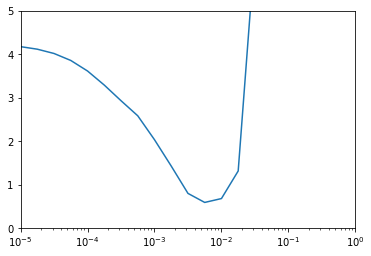

In [7]:
import matplotlib.pyplot as plt
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-5, 1, 0, 5])
plt.show()

In [8]:
# the loss is decreased fast when LR is between 1e-4 and 1e-3
# choose the mid point between 1e-4 and 7e-4
lr = 1e-3
base_model_16 = tf.keras.applications.vgg16.VGG16(include_top=False,
                      input_shape = (imsize,imsize,3),
                      weights = 'imagenet')

# freeze all the layers of VGG, so they won't be trained.
for layer in base_model_16.layers:
    layer.trainable = False

model_vgg_16 = tf.keras.models.Sequential([
    base_model_16,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=1024, activation='relu'),
    tf.keras.layers.Dense(units=44, activation='softmax')
])

model_vgg_16.compile(optimizer=tf.keras.optimizers.Adam(lr), loss='sparse_categorical_crossentropy', metrics=['acc']) 

history = model_vgg_16.fit(x=x_train, y=y_train,
                          epochs=EPOCHS,
                          batch_size=batch_size,
                          verbose=1)

Epoch 1/20
1/1 [==============================] - 1s 681ms/step - loss: 4.2749 - acc: 0.0455
Epoch 2/20
1/1 [==============================] - 0s 179ms/step - loss: 4.2908 - acc: 0.2386
Epoch 3/20
1/1 [==============================] - 0s 162ms/step - loss: 4.0326 - acc: 0.2670
Epoch 4/20
1/1 [==============================] - 0s 160ms/step - loss: 2.8446 - acc: 0.4091
Epoch 5/20
1/1 [==============================] - 0s 175ms/step - loss: 1.8921 - acc: 0.7386
Epoch 6/20
1/1 [==============================] - 0s 179ms/step - loss: 1.3593 - acc: 0.7273
Epoch 7/20
1/1 [==============================] - 0s 164ms/step - loss: 1.0236 - acc: 0.7386
Epoch 8/20
1/1 [==============================] - 0s 166ms/step - loss: 0.7407 - acc: 0.7955
Epoch 9/20
1/1 [==============================] - 0s 176ms/step - loss: 0.5538 - acc: 0.8693
Epoch 10/20
1/1 [==============================] - 0s 164ms/step - loss: 0.4539 - acc: 0.9148
Epoch 11/20
1/1 [==============================] - 0s 167ms/step - lo

In [9]:
model_vgg_16.evaluate(x_test, y_test)

3/3 [==============================] - 2s 336ms/step - loss: 1.8674 - acc: 0.6316


[1.8673555850982666, 0.6315789222717285]

# Contrastive loss

In [10]:
# Helper Function 

# Create positive pairs and negative pairs
import random
def create_pairs(images, labels):
    numClasses = 44
    # initialize two empty lists to hold the (image, image) pairs and
    # labels to indicate if a pair is positive (0) or negative (1)
    np.random.seed(2021)
    pairImages = []
    pairLabels = []
    
    # calculate the total number of classes present in the dataset
    # and then build a list of indexes for each class label that
    # provides the indexes for all examples with a given label
    idx = [np.where(labels == i)[0] for i in range(44)]
    
    # loop voer all images
    for idxA in range(len(images)):
        # grab the current image and label belonging to the current iteration
        currentImage = images[idxA]
        label = labels[idxA]
        
        # randomly pick on an image that belongs to the *same* class label
        posId = random.choice(idx[label])
        posImage = images[posId]
        
        # prepare a positive pair and update the images and labels
        pairImages.append([currentImage, posImage])
        pairLabels.append([0])
        
        # grab the indices for each of the class labels *not* equal to
        # the current label and randomly pick an image corresponding
        # to a label *not* equal to the current label
        negId = np.where(labels != label)[0]
        negIdx = random.choice(negId)
        negImage = images[negIdx]
        
        # prepare a negative pair of images and update out lists
        pairImages.append([currentImage, negImage])
        pairLabels.append([1])
    
    return (np.array(pairImages), np.array(pairLabels))



# Function to calculate the distance between two images (Euclidean Distance used here)
import tensorflow.keras.backend as K
def euclidean_distance(vectors):
    # unpack the vectors into separate lists
    (featsA, featsB) = vectors
    # compute the sum of squared distances between the vectors
    sumSquared = K.sum(K.square(featsA - featsB), axis=1,
                       keepdims=True)
    # return the euclidean distance between the vectors
    return K.sqrt(K.maximum(sumSquared, K.epsilon()))


# contrastive loss function
def contrastive_loss(y, preds, margin=1):
    # explicitly cast the true class label data type to the predicted
    # class label data type (otherwise we run the risk of having two
    # separate data types, causing TensorFlow to error out)
    y = tf.cast(y, preds.dtype)
    # calculate the contrastive loss between the true labels and
    # the predicted labels
    squaredPreds = K.square(preds)
    squaredMargin = K.square(K.maximum(margin - preds, 0))
    loss = K.mean((1 - y) * squaredPreds + y * squaredMargin)
    # return the computed contrastive loss to the calling function
    return loss

In [11]:
(pairTrain, labelTrain) = create_pairs(x_train, y_train)

In [12]:
lr = 1e-5
embeddingDim = 128

base_model_16 = tf.keras.applications.vgg16.VGG16(include_top=False,
                  input_shape = (imsize,imsize,3),
                  weights = 'imagenet')

# freeze all the layers of VGG, so they won't be trained.
for layer in base_model_16.layers:
    layer.trainable = False

    

model_cl = tf.keras.models.Sequential([
    base_model_16,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=1024, activation='relu'),
    tf.keras.layers.Dense(embeddingDim, activation=None), # No activation on final dense layer
    tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1)) # L2 normalize embeddings
])

    
imgA = tf.keras.layers.Input(shape=((imsize, imsize, 3)))
imgB = tf.keras.layers.Input(shape=((imsize, imsize, 3)))
    
featsA = model_cl(imgA)
featsB = model_cl(imgB)
   
distance = tf.keras.layers.Lambda(euclidean_distance)([featsA, featsB])
model = tf.keras.Model(inputs=[imgA, imgB], outputs=distance)
model.compile(loss=contrastive_loss, optimizer=tf.keras.optimizers.Adam(lr))

history = model.fit([pairTrain[:, 0], pairTrain[:, 1]], labelTrain[:],
                    batch_size = batch_size, 
                    epochs=EPOCHS, 
                    verbose=1,
                    callbacks = [lr_schedule])

Epoch 1/20
2/2 [==============================] - 25s 7s/step - loss: 0.1956
Epoch 2/20
2/2 [==============================] - 1s 195ms/step - loss: 0.1880
Epoch 3/20
2/2 [==============================] - 1s 181ms/step - loss: 0.1737
Epoch 4/20
2/2 [==============================] - 1s 176ms/step - loss: 0.1597
Epoch 5/20
2/2 [==============================] - 1s 195ms/step - loss: 0.1474
Epoch 6/20
2/2 [==============================] - 1s 181ms/step - loss: 0.1196
Epoch 7/20
2/2 [==============================] - 1s 183ms/step - loss: 0.0965
Epoch 8/20
2/2 [==============================] - 1s 204ms/step - loss: 0.0717
Epoch 9/20
2/2 [==============================] - 1s 198ms/step - loss: 0.0584
Epoch 10/20
2/2 [==============================] - 1s 192ms/step - loss: 0.0473
Epoch 11/20
2/2 [==============================] - 1s 191ms/step - loss: 0.0389
Epoch 12/20
2/2 [==============================] - 1s 180ms/step - loss: 0.0304
Epoch 13/20
2/2 [==============================] - 

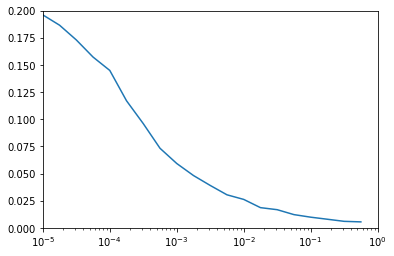

In [13]:
import matplotlib.pyplot as plt
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-5, 1, 0, 0.2])
plt.show()

In [14]:
# the loss is decreased fast when LR is between 1e-4 and 8e-4
# choose the mid point between 1e-5 and 1e-4
lr = 4e-4

base_model_16 = tf.keras.applications.vgg16.VGG16(include_top=False,
                  input_shape = (imsize,imsize,3),
                  weights = 'imagenet')

# freeze all the layers of VGG, so they won't be trained.
for layer in base_model_16.layers:
    layer.trainable = False

model_cl = tf.keras.models.Sequential([
    base_model_16,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=1024, activation='relu'),
    tf.keras.layers.Dense(embeddingDim, activation=None), # No activation on final dense layer
    tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1)) # L2 normalize embeddings
])
    
imgA = tf.keras.layers.Input(shape=((imsize, imsize, 3)))
imgB = tf.keras.layers.Input(shape=((imsize, imsize, 3)))
    
featsA = model_cl(imgA)
featsB = model_cl(imgB)
   
distance = tf.keras.layers.Lambda(euclidean_distance)([featsA, featsB])
model = tf.keras.Model(inputs=[imgA, imgB], outputs=distance)
model.compile(loss=contrastive_loss, optimizer=tf.keras.optimizers.Adam(lr))

history = model.fit([pairTrain[:, 0], pairTrain[:, 1]], labelTrain[:],
                    batch_size = batch_size, 
                    epochs=EPOCHS, 
                    verbose=1)

Epoch 1/20
2/2 [==============================] - 2s 183ms/step - loss: 0.2119
Epoch 2/20
2/2 [==============================] - 1s 177ms/step - loss: 0.2055
Epoch 3/20
2/2 [==============================] - 1s 186ms/step - loss: 0.2073
Epoch 4/20
2/2 [==============================] - 1s 184ms/step - loss: 0.1459
Epoch 5/20
2/2 [==============================] - 1s 191ms/step - loss: 0.1098
Epoch 6/20
2/2 [==============================] - 1s 187ms/step - loss: 0.1057
Epoch 7/20
2/2 [==============================] - 1s 185ms/step - loss: 0.0924
Epoch 8/20
2/2 [==============================] - 1s 188ms/step - loss: 0.0749
Epoch 9/20
2/2 [==============================] - 1s 183ms/step - loss: 0.0676
Epoch 10/20
2/2 [==============================] - 1s 193ms/step - loss: 0.0584
Epoch 11/20
2/2 [==============================] - 1s 185ms/step - loss: 0.0492
Epoch 12/20
2/2 [==============================] - 1s 181ms/step - loss: 0.0440
Epoch 13/20
2/2 [==============================] 

In [15]:
from sklearn.neighbors import KNeighborsClassifier

def acc_cl(x_test, y_test, k = 1):
    embedding_train_cl = []
    for i in range(len(y_train)):
        embedding_train_cl.append(model_cl(x_train[i].reshape(1, imsize, imsize, 3))[0])
    embedding_train_cl = np.array(embedding_train_cl, dtype=float) 

    knn_cl = KNeighborsClassifier(n_neighbors = k)
    knn_cl.fit(embedding_train_cl, y_train)
    
    x_test_embedding = model_cl(x_test)
    acc_close = round(knn_cl.score(x_test_embedding, y_test), 2)
    print('The accuracy on the Closed Dataset with contrastive loss is {}'.format(acc_close))
    
    return acc_close

# Tuning k value of kNN

In [16]:
K = [1, 2, 3, 4, 5, 6, 7, 8, 9]
acc_c = []
for i in K:
    acc_c.append(acc_cl(x_test, y_test, k = i))

The accuracy on the Closed Dataset with contrastive loss is 0.54
The accuracy on the Closed Dataset with contrastive loss is 0.54
The accuracy on the Closed Dataset with contrastive loss is 0.53
The accuracy on the Closed Dataset with contrastive loss is 0.55
The accuracy on the Closed Dataset with contrastive loss is 0.53
The accuracy on the Closed Dataset with contrastive loss is 0.5
The accuracy on the Closed Dataset with contrastive loss is 0.49
The accuracy on the Closed Dataset with contrastive loss is 0.49
The accuracy on the Closed Dataset with contrastive loss is 0.49


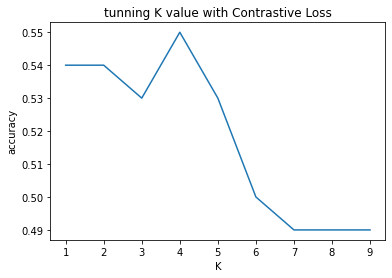

In [17]:
# k = 2, highest accuracy.
plt.plot(K, acc_c)
plt.xlabel('K')
plt.ylabel('accuracy')
plt.title('tunning K value with Contrastive Loss')
plt.show()

# Triplet loss

In [18]:
lr = 1e-5

base_model_16 = tf.keras.applications.vgg16.VGG16(include_top=False,
                      input_shape = (imsize, imsize, 3),
                      weights = 'imagenet')

# freeze all the layers of VGG, so they won't be trained.
for layer in base_model_16.layers:
    layer.trainable = False

model_tl = tf.keras.models.Sequential([
    base_model_16,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=1024, activation='relu'),
    tf.keras.layers.Dense(embeddingDim, activation=None), # No activation on final dense layer
    tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1)) # L2 normalize embeddings
])

model_tl.compile(
    optimizer=tf.keras.optimizers.Adam(lr),
    loss=tfa.losses.TripletSemiHardLoss())

history = model_tl.fit(x=x_train, y= y_train,
                       batch_size=batch_size,
                       epochs=EPOCHS, 
                       verbose=1, 
                       callbacks = [lr_schedule])

Epoch 1/20
1/1 [==============================] - 2s 2s/step - loss: 0.9816
Epoch 2/20
1/1 [==============================] - 0s 170ms/step - loss: 0.9804
Epoch 3/20
1/1 [==============================] - 0s 172ms/step - loss: 0.9779
Epoch 4/20
1/1 [==============================] - 0s 184ms/step - loss: 0.9735
Epoch 5/20
1/1 [==============================] - 0s 169ms/step - loss: 0.9640
Epoch 6/20
1/1 [==============================] - 0s 164ms/step - loss: 0.9403
Epoch 7/20
1/1 [==============================] - 0s 168ms/step - loss: 0.8844
Epoch 8/20
1/1 [==============================] - 0s 167ms/step - loss: 0.7591
Epoch 9/20
1/1 [==============================] - 0s 169ms/step - loss: 0.6891
Epoch 10/20
1/1 [==============================] - 0s 183ms/step - loss: 0.7110
Epoch 11/20
1/1 [==============================] - 0s 170ms/step - loss: 0.6001
Epoch 12/20
1/1 [==============================] - 0s 171ms/step - loss: 0.5995
Epoch 13/20
1/1 [==============================] - 0

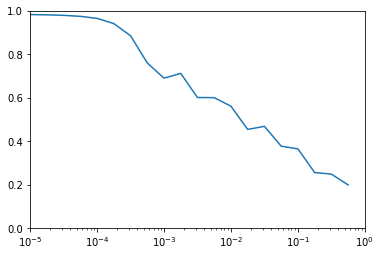

In [19]:
import matplotlib.pyplot as plt
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-5, 1, 0, 1])
plt.show()

In [20]:
# the loss is decreased fast when LR is between 5e-4 and 7e-4
# choose the mid point between 8e-5 and 4e-4
lr = 6e-4

base_model_16 = tf.keras.applications.vgg16.VGG16(include_top=False,
                      input_shape = (imsize, imsize, 3),
                      weights = 'imagenet')

# freeze all the layers of VGG, so they won't be trained.
for layer in base_model_16.layers:
    layer.trainable = False

model_tl = tf.keras.models.Sequential([
    base_model_16,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=1024, activation='relu'),
    tf.keras.layers.Dense(embeddingDim, activation=None), # No activation on final dense layer
    tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1)) # L2 normalize embeddings
])

model_tl.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tfa.losses.TripletSemiHardLoss())

history = model_tl.fit(x=x_train, y= y_train,
                       batch_size=batch_size,
                       epochs=EPOCHS, 
                       verbose=1)

Epoch 1/20
1/1 [==============================] - 1s 755ms/step - loss: 0.9835
Epoch 2/20
1/1 [==============================] - 0s 162ms/step - loss: 0.9190
Epoch 3/20
1/1 [==============================] - 0s 168ms/step - loss: 0.7628
Epoch 4/20
1/1 [==============================] - 0s 167ms/step - loss: 0.7406
Epoch 5/20
1/1 [==============================] - 0s 166ms/step - loss: 0.6029
Epoch 6/20
1/1 [==============================] - 0s 170ms/step - loss: 0.4482
Epoch 7/20
1/1 [==============================] - 0s 169ms/step - loss: 0.4157
Epoch 8/20
1/1 [==============================] - 0s 180ms/step - loss: 0.3239
Epoch 9/20
1/1 [==============================] - 0s 170ms/step - loss: 0.2653
Epoch 10/20
1/1 [==============================] - 0s 167ms/step - loss: 0.2307
Epoch 11/20
1/1 [==============================] - 0s 166ms/step - loss: 0.1820
Epoch 12/20
1/1 [==============================] - 0s 170ms/step - loss: 0.1462
Epoch 13/20
1/1 [==============================] 

In [21]:
def acc_tl(x_test, y_test, k = 1):
    embedding_train_tl = []
    for i in range(len(y_train)):
        embedding_train_tl.append(model_tl(x_train[i].reshape(1, imsize, imsize, 3))[0])
        
    embedding_train_tl = np.array(embedding_train_tl, dtype=float) 

    knn_tl = KNeighborsClassifier(n_neighbors = k)
    knn_tl.fit(embedding_train_tl, y_train)
    
    x_test_embedding = model_tl(x_test)
    acc_close = round(knn_tl.score(x_test_embedding, y_test), 2)
    print('The accuracy on the Closed Dataset with triplet loss is {}'.format(acc_close))
    
    return acc_close

# tuning k value of kNN

In [22]:
K = [1, 2, 3, 4, 5, 6, 7, 8, 9]
acc_t = []
for i in K:
    acc_t.append(acc_tl(x_test, y_test, k = i))

The accuracy on the Closed Dataset with triplet loss is 0.72
The accuracy on the Closed Dataset with triplet loss is 0.67
The accuracy on the Closed Dataset with triplet loss is 0.64
The accuracy on the Closed Dataset with triplet loss is 0.64
The accuracy on the Closed Dataset with triplet loss is 0.63
The accuracy on the Closed Dataset with triplet loss is 0.63
The accuracy on the Closed Dataset with triplet loss is 0.58
The accuracy on the Closed Dataset with triplet loss is 0.55
The accuracy on the Closed Dataset with triplet loss is 0.55


# tuning k value of kNN

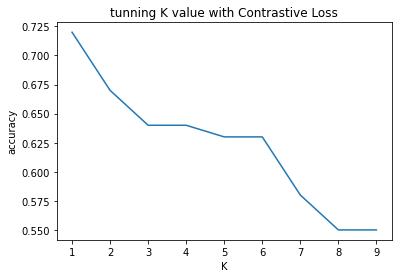

In [23]:
# k = 1, highest accuracy.
plt.plot(K, acc_t)
plt.xlabel('K')
plt.ylabel('accuracy')
plt.title('tunning K value with Contrastive Loss')
plt.show()